<a href="https://colab.research.google.com/github/oksuhit/c-/blob/main/PCNN_2016.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import cv2
import gc
import glob
import numpy as np
import matplotlib.pyplot as plt
import tifffile as tiff
!pip install rasterio
import rasterio
import os
# %tensorflow_version 1.x
import tensorflow as tf

from tensorflow.keras.models import Model, Sequential

from tensorflow.keras.layers import Input
from keras.layers import Conv2D, Add , Concatenate
from keras.optimizers import Adam

from keras.layers import Input, Dense
from keras.models import Model
from scipy.io import loadmat
import numpy as np
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

import tensorflow

%matplotlib inline

import random
import re
from PIL import Image
import math

# %tensorflow_version 1.x
import tensorflow as tf

from numpy.random import seed

from pylab import *
import sys
import pandas as pd
import albumentations as A
from albumentations import  Compose, RandomBrightness, HorizontalFlip, VerticalFlip, Rotate
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import *
from tqdm import *
from tensorflow.keras.utils import Sequence
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Convolution2D, ZeroPadding2D, MaxPooling2D, Conv2D, SeparableConv2D, Conv2DTranspose
from tensorflow.keras.layers import Input, Add, Dropout, Permute
from tensorflow.keras.activations import sigmoid, softmax, relu
from tensorflow.keras.losses import CategoricalCrossentropy, BinaryCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Accuracy, Precision, Recall, AUC, MeanIoU, BinaryAccuracy, binary_crossentropy

from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, auc
from sklearn.metrics import precision_recall_fscore_support, precision_recall_curve, matthews_corrcoef
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, jaccard_score, classification_report
from sklearn.metrics import ConfusionMatrixDisplay as CMD
print(tf.__version__)

2.14.0


# mounting google drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
from google.colab.patches import cv2_imshow
import scipy.io

In [6]:
path= '/content/drive/MyDrive/PAirMax'
if os.getcwd() is not path:
  os.chdir(path)

# trainig image creation

In [7]:

def training_image_creation(img_ms, img_pan, n_factor=4):
    """
    This function generates the blurred version of the original input multispectral image, and concatenate it with the
    downsampled panchromatic so as to create the training sample used for Pansharpening Convolutional Neural Network (PCNN)
    model training.

    Inputs:
    - img_ms: Numpy array of the original multispectral image which is to be used for PCNN model training
    - img_pan: Numpy array of the original panchromatic image which is to be used for PCNN model training
    - n_factor: The ratio of pixel resolution of multispectral image to that of the panchromatic image

    Outputs:
    - training_sample_array: Numpy array of concatenated blurred multispectral image and downsampled panchromatic image to be
                             used for PCNN model training

    """

    blurred_img_ms = np.zeros((img_ms.shape))

    for i in range(img_ms.shape[2]):
        blurred_img_ms[:, :, i] = cv2.GaussianBlur(img_ms[:, :, i], (5, 5), 0)

    blurred_img_ms_small = cv2.resize(blurred_img_ms, (int(img_ms.shape[1] / n_factor), int(img_ms.shape[0] / n_factor)),
                                      interpolation = cv2.INTER_AREA)
    blurred_img_ms_sam = cv2.resize(blurred_img_ms_small, (img_ms.shape[1], img_ms.shape[0]), interpolation = cv2.INTER_CUBIC)

    downsampled_img_pan = cv2.resize(img_pan, (img_ms.shape[1], img_ms.shape[0]),
                                     interpolation = cv2.INTER_AREA)[:, :, np.newaxis]

    training_sample_array = np.concatenate((blurred_img_ms_sam, downsampled_img_pan), axis = 2)

    return training_sample_array



# cliping image

In [8]:
def image_clip_to_segment(image_ms_array, train_image_array, image_height_size, image_width_size, percentage_overlap,
                          buffer):
    """
    This function is used to cut up original input images of any size into segments of a fixed size, with empty clipped areas
    padded with zeros to ensure that segments are of equal fixed sizes and contain valid data values. The function then
    returns a 4 - dimensional array containing the entire original input multispectral image and its corresponding
    training image in the form of fixed size segments as training data inputs for the PCNN model.

    Inputs:
    - image_ms_array: Numpy array of original input multispectral image to be used for PCNN model training
    - train_image_array: Numpy array of training sample images to be used for PCNN model training
    - image_height_size: Height of image to be fed into the PCNN model for training
    - image_width_size: Width of image to be fed into the PCNN model for training
    - percentage_overlap: Percentage of overlap between image patches extracted by sliding window to be used for model
                          training
    - buffer: Percentage allowance for image patch to be populated by reflected values for positions with no valid data values

    Output:
    - train_segment_array: 4 - Dimensional numpy array of training sample images to serve as training data for PCNN model
    - image_ms_segment_array: 4 - Dimensional numpy array of original input multispectral image to serve as target data for
                           training PCNN model

    """

    y_size = ((image_ms_array.shape[0] // image_height_size) + 1) * image_height_size
    y_pad = int(y_size - image_ms_array.shape[0])
    x_size = ((image_ms_array.shape[1] // image_width_size) + 1) * image_width_size
    x_pad = int(x_size - image_ms_array.shape[1])

    img_complete = np.pad(image_ms_array, ((0, y_pad), (0, x_pad), (0, 0)), mode = 'symmetric').astype(image_ms_array.dtype)
    train_complete = np.pad(train_image_array, ((0, y_pad), (0, x_pad), (0, 0)),
                            mode = 'symmetric').astype(train_image_array.dtype)

    img_list = []
    train_list = []

    for i in range(0, int(img_complete.shape[0] - (2 - buffer) * image_height_size),
                   int((1 - percentage_overlap) * image_height_size)):
        for j in range(0, int(img_complete.shape[1] - (2 - buffer) * image_width_size),
                       int((1 - percentage_overlap) * image_width_size)):
            img_original = img_complete[i : i + image_height_size, j : j + image_width_size, 0 : image_ms_array.shape[2]]
            img_list.append(img_original)
            train_original = train_complete[i : i + image_height_size, j : j + image_width_size, :]
            train_list.append(train_original)

    image_segment_array = np.zeros((len(img_list), image_height_size, image_width_size, image_ms_array.shape[2]))
    train_segment_array = np.zeros((len(train_list), image_height_size, image_width_size, train_image_array.shape[2]))

    for index in range(len(img_list)):
        image_segment_array[index] = img_list[index]
        train_segment_array[index] = train_list[index]

    return train_segment_array, image_segment_array

# trianing data generation

In [9]:
def training_data_generation(DATA_DIR, img_height_size, img_width_size, perc, buff):
    """
    This function is used to read in files from a folder which contains the images which are to be used for training the
    PCNN model, then returns 2 numpy arrays containing the training and target data for all the images in the folder so that
    they can be used for PCNN model training.

    Inputs:
    - DATA_DIR: File path of the folder containing the images to be used as training data for PCNN model.
    - img_height_size: Height of image segment to be used for PCNN model training
    - img_width_size: Width of image segment to be used for PCNN model training
    - perc: Percentage of overlap between image patches extracted by sliding window to be used for model training
    - buff: Percentage allowance for image patch to be populated by reflected values for positions with no valid data values

    Outputs:
    - train_full_array: 4 - Dimensional numpy array of concatenated multispectral and downsampled panchromatic images to serve as
                            training data for PCNN model
    - img_full_array: 4 - Dimensional numpy array of original input multispectral image to serve as target data for training PCNN model

    """

    if perc < 0 or perc > 1:
        raise ValueError('Please input a number between 0 and 1 (inclusive) for perc.')

    if buff < 0 or buff > 1:
        raise ValueError('Please input a number between 0 and 1 (inclusive) for buff.')

    img_MS_files = glob.glob('MS_LR*.tif')
    img_PAN_files = glob.glob('PAN*.tif')
    img_GT_files = glob.glob('GT*.tif')

    img_array_list = []
    train_array_list = []

    for file in range(5):

        switch = {
            0:'1',
            1:'2',
            2:'3',
            3:'4',
            4:'5'
        }
        with rasterio.open('/content/drive/MyDrive/PAirMax/RR/MS_LR/MS_LR'+switch[file]+'.tif') as f:
            metadata = f.profile
            ms_img = np.transpose(f.read(tuple(np.arange(metadata['count']) + 1)), [1, 2, 0])
        with rasterio.open('/content/drive/MyDrive/PAirMax/RR/PAN/PAN'+switch[file]+'.tif') as g:
            metadata_pan = g.profile
            pan_img = g.read(1)

        with rasterio.open('/content/drive/MyDrive/PAirMax/GT/GT'+switch[file]+'.tif') as f:
            metadata = f.profile
            gt_img = np.transpose(f.read(tuple(np.arange(metadata['count']) + 1)), [1, 2, 0])


        train_img = training_image_creation(ms_img, pan_img)

        train_array, img_array = image_clip_to_segment(ms_img, train_img, img_height_size, img_width_size,
                                                       percentage_overlap = perc, buffer = buff)

        img_array_list.append(img_array)
        train_array_list.append(train_array)

    img_full_array = np.concatenate(img_array_list, axis = 0)
    train_full_array = np.concatenate(train_array_list, axis = 0)

    del img_MS_files, img_PAN_files
    gc.collect()

    return train_full_array, img_full_array


In [10]:
train_full_array, img_full_array = (training_data_generation('x', 64, 64, 0.5, 0.5))

In [11]:
print(train_full_array.shape)

# ms_img = cv2. resize(img_full_array[0], (128, 128))
# cv2_imshow(ms_img)
# ms_img1 = cv2. resize(train_full_array[0][:,:,:3], (128, 128))
# cv2_imshow(ms_img1)
# ms_img2 = cv2. resize(train_full_array[0][:,:,3:], (128, 128))
# cv2_imshow(ms_img2)
x_mst=train_full_array[:,:,:,:4]
x_pan=train_full_array[:,:,:,4:]
print(img_full_array.shape)
print(x_mst.shape)
print(x_pan.shape)

(29, 64, 64, 5)
(29, 64, 64, 4)
(29, 64, 64, 4)
(29, 64, 64, 1)


In [12]:
def image_model_predict(input_ms_image_filename, input_pan_image_filename, output_filename,
                        img_height_size, img_width_size, fitted_model,
                        percentage_overlap, write):
    """
    This function cuts up an image into segments of fixed size, and feeds each segment to the model for upsampling. The
    output upsampled segment is then allocated to its corresponding location in the image in order to obtain the complete upsampled
    image, after which it can be written to file.

    Inputs:
    - input_ms_image_filename: File path of the multispectral image to be pansharpened by the PCNN model
    - input_pan_image_filename: File path of the panchromatic image to be used by the PCNN model
    - output_filename: File path to write the file
    - img_height_size: Height of image segment to be used for PCNN model pansharpening
    - img_width_size: Width of image segment to be used for PCNN model pansharpening
    - ms_to_pan_ratio: The ratio of pixel resolution of multispectral image to that of panchromatic image
    - fitted_model: Keras model containing the trained PCNN model along with its trained weights
    - percentage_overlap: Percentage of overlap between adjacent patches of image for model prediction
    - write: Boolean indicating whether to write the pansharpened image to file


    Output:
    - pred_img_final: Numpy array which represents the pansharpened image

    """

    with rasterio.open(input_ms_image_filename) as f:
        metadata = f.profile
        ms_img = np.transpose(f.read(tuple(np.arange(metadata['count']) + 1)), [1, 2, 0])

    with rasterio.open(input_pan_image_filename) as g:
        metadata_pan = g.profile
        pan_img = np.expand_dims(g.read(1), axis = 2)

    ms_to_pan_ratio = metadata['transform'][0] / metadata_pan['transform'][0]
    ms_img_upsampled = cv2.resize(ms_img, (int(ms_img.shape[1] * ms_to_pan_ratio), int(ms_img.shape[0] * ms_to_pan_ratio)),
                                  interpolation = cv2.INTER_CUBIC)
    pred_stack = np.concatenate((ms_img_upsampled, pan_img), axis = 2)


    y_size = ((pred_stack.shape[0] // img_height_size) + 1) * img_height_size
    y_pad = int(y_size - pred_stack.shape[0])
    x_size = ((pred_stack.shape[1] // img_width_size) + 1) * img_width_size
    x_pad = int(x_size - pred_stack.shape[1])

    img_complete = np.pad(pred_stack, ((0, y_pad), (0, x_pad), (0, 0)), mode = 'symmetric').astype(pred_stack.dtype)

    pred_img = np.zeros((img_complete.shape[0], img_complete.shape[1], ms_img.shape[2]))
    weight_mask = np.zeros((img_complete.shape[0], img_complete.shape[1], 1))
    img_holder = np.zeros((1, img_height_size, img_width_size, img_complete.shape[2]))


    for i in range(0, img_complete.shape[0] - img_height_size + 1, int((1 - percentage_overlap) * img_height_size)):
        for j in range(0, img_complete.shape[1] - img_width_size + 1, int((1 - percentage_overlap) * img_width_size)):
            img_holder[0] = img_complete[i : (i + img_height_size), j : (j + img_width_size), 0 : pred_stack.shape[2]]
            preds = fitted_model.predict(img_holder)
            pred_img[i : i + img_height_size, j : j + img_width_size, :] += preds[0, :, :, :]
            weight_mask[i : i + img_height_size, j : j + img_width_size, 0] += 1

    pred_img_complete = pred_img[0 : pan_img.shape[0], 0 : pan_img.shape[1], :]
    weight_mask_complete = weight_mask[0 : pan_img.shape[0], 0 : pan_img.shape[1], 0][:, :, np.newaxis]
    pred_img_final = (pred_img_complete / weight_mask_complete).astype(metadata['dtype'])


    metadata_pan['count'] = ms_img_upsampled.shape[2]
    with rasterio.open(output_filename, 'w', **metadata_pan) as dst:
        dst.write(np.transpose(pred_img_final, [2, 0, 1]))

    return pred_img_final

# PCNN model (2016)

In [ ]:
def pcnn_model(image_height_size, image_width_size, n_bands, n1 = 64, n2 = 32, f1 = 9, f2 = 5, f3 = 5, l_r = 0.0001):
    """
    This function creates the PCNN model which needs to be trained, following the main architecture as described in the
    paper 'Pansharpening by Convolutional Neural Networks' by Masi G., Cozzolino D., Verdoliva L., Scarpa G. (2016)

    Inputs:
    - image_height_size: Height of image segment to be used for PCNN model training
    - image_width_size: Width of image segment to be used for PCNN model training
    - n_bands: Number of channels contained in the input images (multispectral bands and panchromatic band)
    - n1: Number of filters for the first hidden convolutional layer
    - n2: Number of filters for the second hidden convolutional layer
    - f1: size of kernel to be used for the first convolutional layer
    - f2: size of kernel to be used for the second convolutional layer
    - f3: size of kernel to be used for the last convolutional filter
    - l_r: Learning rate to be used by the Adam optimizer

    Outputs:
    - model: PCNN model compiled using the parameters defined in the input, and compiled with the Adam optimizer and
             mean squared error loss function

    """

    img_input = Input(shape = (image_height_size, image_width_size, n_bands))
    conv1 = Conv2D(n1, (f1, f1), padding = 'same', activation = 'relu')(img_input)
    conv2 = Conv2D(n2, (f2, f2), padding = 'same', activation = 'relu')(conv1)
    conv3 = Conv2D(n_bands - 1, (f3, f3), padding = 'same')(conv2)

    model = Model(inputs = img_input, outputs = conv3)
    model.compile(optimizer = Adam(lr = l_r), loss = 'mse', metrics = ['mse','accuracy'])

    return model




In [ ]:
model = pcnn_model(64, 64, 5)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 5)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 64)        25984     
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        51232     
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 4)         3204      
                                                                 
Total params: 80420 (314.14 KB)
Trainable params: 80420 (314.14 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
history = model.fit(train_full_array, img_full_array,
          batch_size=16,
          epochs=40,
          verbose=1)

Epoch 1/40
2/2 [==============================] - 3s 798ms/step - loss: 332740.1875 - mse: 332740.1875 - accuracy: 0.2178
Epoch 2/40
2/2 [==============================] - 2s 782ms/step - loss: 80303.6484 - mse: 80303.6484 - accuracy: 0.4319
Epoch 3/40
2/2 [==============================] - 2s 757ms/step - loss: 78781.0781 - mse: 78781.0781 - accuracy: 0.7624
Epoch 4/40
2/2 [==============================] - 2s 874ms/step - loss: 65651.6250 - mse: 65651.6250 - accuracy: 0.7194
Epoch 5/40
2/2 [==============================] - 3s 1s/step - loss: 55014.3672 - mse: 55014.3672 - accuracy: 0.7675
Epoch 6/40
2/2 [==============================] - 3s 1s/step - loss: 48452.7773 - mse: 48452.7773 - accuracy: 0.7390
Epoch 7/40
2/2 [==============================] - 2s 861ms/step - loss: 44564.5859 - mse: 44564.5859 - accuracy: 0.7298
Epoch 8/40
2/2 [==============================] - 2s 749ms/step - loss: 39169.7422 - mse: 39169.7422 - accuracy: 0.7469
Epoch 9/40
2/2 [============================

In [ ]:
output=image_model_predict('/content/drive/MyDrive/PAirMax/RR/MS_LR/MS_LR1.tif', '/content/drive/MyDrive/PAirMax/RR/PAN/PAN1.tif', '/content/drive/MyDrive/PAirMax/RR/PAN_SH/PAN_SH1.tif',
                        64, 64, model,
                        0.5, 1)

1/1 [==============================] - 0s 72ms/step


In [42]:
import rasterio
from rasterio.plot import show

(512, 512)
(128, 128)


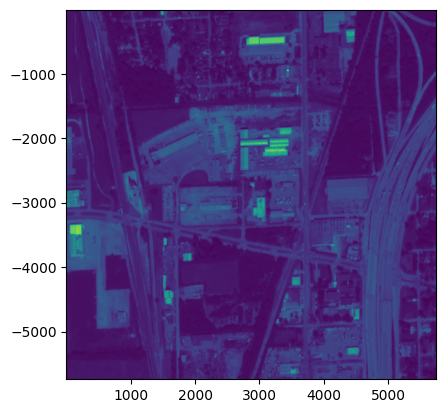

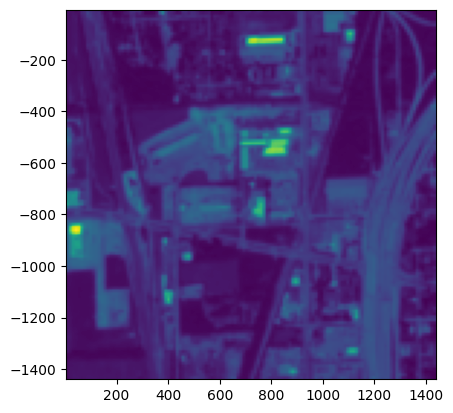

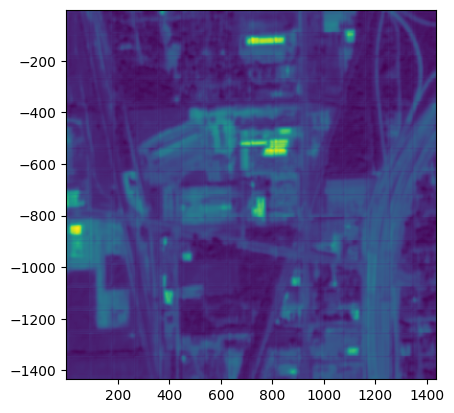

<Axes: >

In [ ]:
gt = rasterio.open(r'/content/drive/MyDrive/PAirMax/GT/GT1.tif')
ms_lr = rasterio.open(r'/content/drive/MyDrive/PAirMax/RR/MS_LR/MS_LR1.tif')
out = rasterio.open(r'/content/drive/MyDrive/PAirMax/RR/PAN_SH/PAN_SH1.tif')
print(gt.shape)
print(ms_lr.shape)
show(gt)
show(ms_lr)
show(out)

(4, 512, 512)


(<Figure size 988.8x604.8 with 1 Axes>,
 <Axes: >,
 <matplotlib.image.AxesImage at 0x7e9e9cdc6b00>)

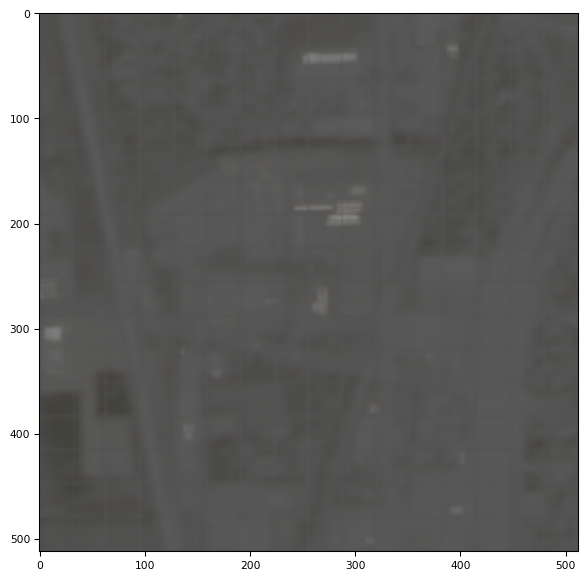

In [ ]:
PAN_sh = tiff.imread('/content/drive/MyDrive/PAirMax/RR/PAN_SH/PAN_SH1.tif')
print(PAN_sh.shape)
tiff.imshow(PAN_sh)

In [ ]:
import matplotlib.pyplot as plt

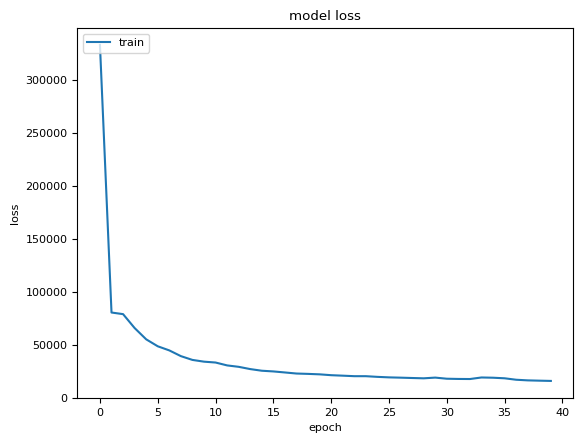

In [ ]:
plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

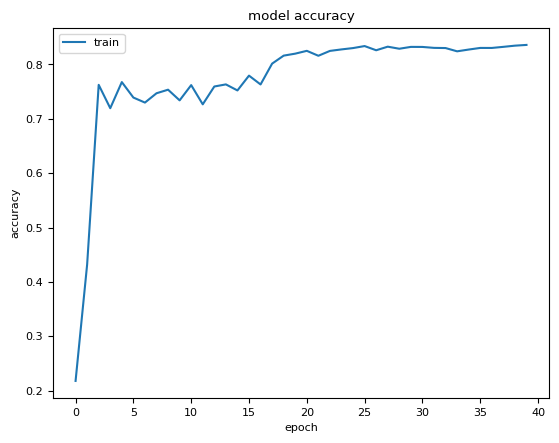

In [ ]:
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [33]:
!pip install sewar
from sewar.full_ref import mse, rmse, psnr, uqi, ssim, ergas, scc, rase, sam, msssim, vifp
from sewar.no_ref import d_lambda, d_s, qnr

  Preparing metadata (setup.py) ... done
  Created wheel for sewar: filename=sewar-0.4.6-py3-none-any.whl size=11420 sha256=b5372cd6d747b997a5ab123b22e08749eb45d97ec2dfd7b079f810e04826a1c8
  Stored in directory: /root/.cache/pip/wheels/3f/af/02/9c6556ba287b62a945d737def09b8b8c35c9e1d82b9dfae84c
Successfully built sewar


In [ ]:
with rasterio.open('/content/drive/MyDrive/PAirMax/GT/GT1.tif') as f:
        metadata = f.profile
        ms_img = np.transpose(f.read(tuple(np.arange(metadata['count']) + 1)), [1, 2, 0])
# with rasterio.open('../input/dataset4/PAN5.tif') as g:
#         metadata_pan = g.profile
#         pan_img = np.expand_dims(g.read(1), axis = 2)

# ms_to_pan_ratio = metadata['transform'][0] / metadata_pan['transform'][0]
with rasterio.open('/content/drive/MyDrive/PAirMax/RR/PAN_SH/PAN_SH1.tif') as f:
        metadata_out = f.profile
        out = np.transpose(f.read(tuple(np.arange(metadata_out['count']) + 1)), [1, 2, 0])


print("SAM: ", sam(out, ms_img))
print("ERGAS: ", ergas(out, ms_img,r=0.02))
print("UQI: ", uqi(out, ms_img))

print("D Lambda: ",d_lambda(ms_img,out))
print("VIFP: ",vifp(ms_img,out))

SAM:  0.12445257085366465
ERGAS:  0.28717848082534314
UQI:  0.9886297736564821
D Lambda:  0.006302822999180853
VIFP:  0.1479229809204844


# Convolutional Auto-Encoder(CAE) (2019)

In [ ]:
def CAE(input_shape=(64, 64, 5)):
  input_img = Input(input_shape)  # adapt this if using `channels_first` image data format
  x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
  x = MaxPooling2D((2, 2), padding='same')(x)
  x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
  x = MaxPooling2D((2, 2), padding='same')(x)
  x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)

  #encoded = MaxPooling2D((2, 2), padding='same')(x)

  x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
  x = UpSampling2D((2, 2))(x)


  x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
  x = UpSampling2D((2, 2))(x)


  x = Conv2D(16, (3, 3), activation='relu', padding = 'same')(x)
  #x = UpSampling2D((2, 2))(x)
  decoded = Conv2D(4, (3, 3), activation='linear', padding='same')(x)

  autoencoder = Model(input_img, decoded, name='CAE')
  # h = tensorflow.keras.losses.Huber()
  autoencoder.compile(optimizer = Adam(learning_rate = 0.001), loss = 'mse', metrics = ['mse', 'accuracy'])

  return autoencoder

In [ ]:
model2 = CAE()
model2.summary()

Model: "CAE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 5)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 16)        736       
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 16)        0         
 D)                                                              
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 8)         1160      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 8)         0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 8)         584     

In [ ]:
img_full_array.shape

(29, 64, 64, 4)

In [ ]:
history2 = model2.fit(train_full_array, img_full_array,
          batch_size=16,
          epochs=40,
          verbose=1,shuffle=True)

Epoch 1/40
2/2 [==============================] - 3s 110ms/step - loss: 424048.8750 - mse: 424048.8750 - accuracy: 0.1188
Epoch 2/40
2/2 [==============================] - 0s 112ms/step - loss: 349469.2500 - mse: 349469.2500 - accuracy: 0.1906
Epoch 3/40
2/2 [==============================] - 0s 104ms/step - loss: 265120.5312 - mse: 265120.5312 - accuracy: 0.2153
Epoch 4/40
2/2 [==============================] - 0s 165ms/step - loss: 215589.7188 - mse: 215589.7188 - accuracy: 0.2233
Epoch 5/40
2/2 [==============================] - 1s 243ms/step - loss: 176907.1094 - mse: 176907.1094 - accuracy: 0.2193
Epoch 6/40
2/2 [==============================] - 0s 105ms/step - loss: 121989.8438 - mse: 121989.8438 - accuracy: 0.2797
Epoch 7/40
2/2 [==============================] - 0s 108ms/step - loss: 94418.3672 - mse: 94418.3672 - accuracy: 0.6616
Epoch 8/40
2/2 [==============================] - 0s 120ms/step - loss: 102300.5312 - mse: 102300.5312 - accuracy: 0.7339
Epoch 9/40
2/2 [==========

In [ ]:
output2=image_model_predict('/content/drive/MyDrive/PAirMax/RR/MS_LR/MS_LR1.tif', '/content/drive/MyDrive/PAirMax/RR/PAN/PAN1.tif', '/content/drive/MyDrive/PAirMax/RR/PAN_SH/PAN_SH_CAE.tif',
                        64, 64, model2,
                        0, 1)

1/1 [==============================] - 0s 86ms/step


(512, 512)
(128, 128)


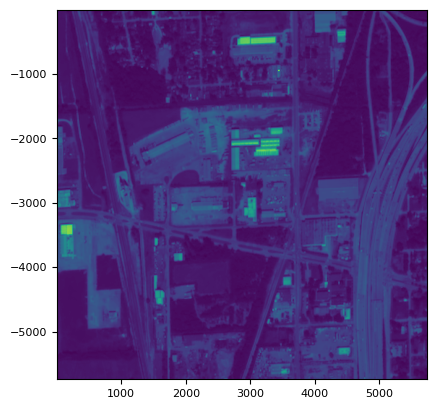

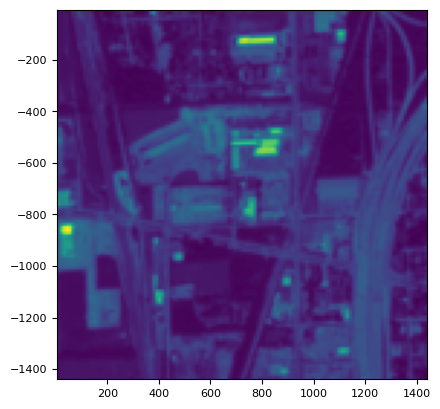

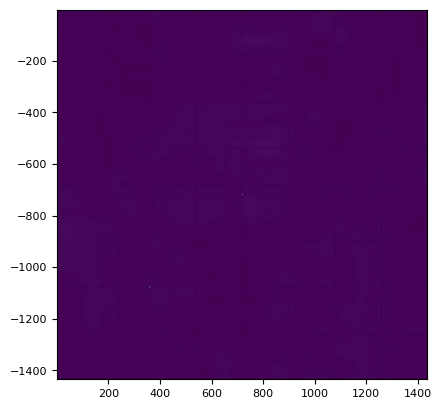

<Axes: >

In [ ]:
gt = rasterio.open(r'/content/drive/MyDrive/PAirMax/GT/GT1.tif')
ms_lr = rasterio.open(r'/content/drive/MyDrive/PAirMax/RR/MS_LR/MS_LR1.tif')
out = rasterio.open(r'/content/drive/MyDrive/PAirMax/RR/PAN_SH/PAN_SH_CAE.tif')
print(gt.shape)
print(ms_lr.shape)
show(gt)
show(ms_lr)
show(out)

(4, 512, 512)


(<Figure size 988.8x604.8 with 1 Axes>,
 <Axes: >,
 <matplotlib.image.AxesImage at 0x7e9e9d14f790>)

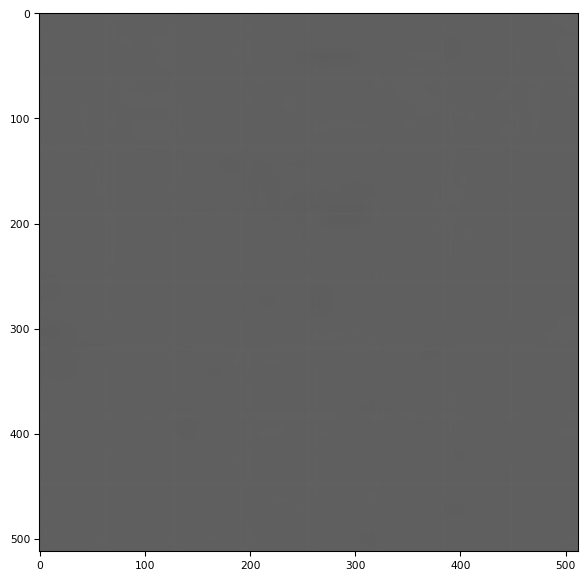

In [ ]:
PAN_sh2 = tiff.imread('/content/drive/MyDrive/PAirMax/RR/PAN_SH/PAN_SH_CAE.tif')
print(PAN_sh2.shape)
tiff.imshow(PAN_sh2)

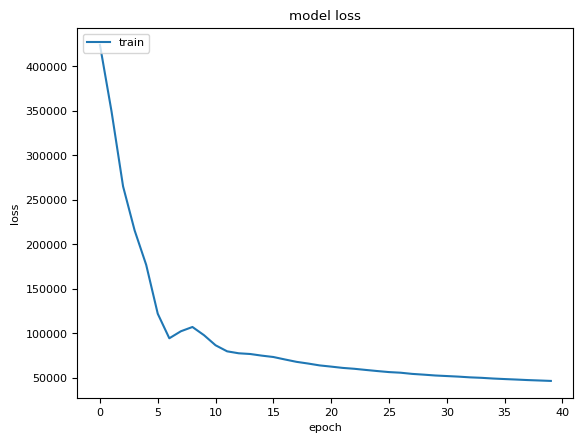

In [ ]:
plt.plot(history2.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

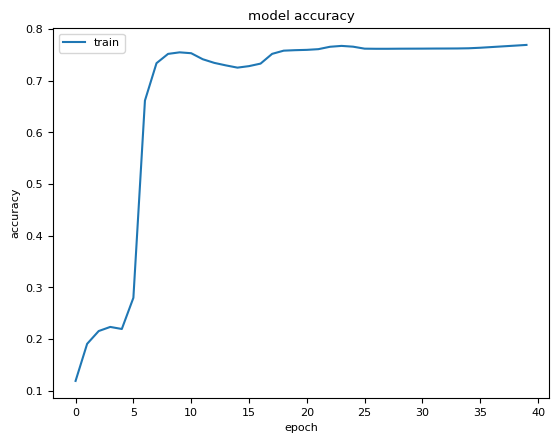

In [ ]:
plt.plot(history2.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
with rasterio.open('/content/drive/MyDrive/PAirMax/GT/GT1.tif') as f:
        metadata = f.profile
        ms_img = np.transpose(f.read(tuple(np.arange(metadata['count']) + 1)), [1, 2, 0])
# with rasterio.open('../input/dataset4/PAN5.tif') as g:
#         metadata_pan = g.profile
#         pan_img = np.expand_dims(g.read(1), axis = 2)

# ms_to_pan_ratio = metadata['transform'][0] / metadata_pan['transform'][0]
with rasterio.open('/content/drive/MyDrive/PAirMax/RR/PAN_SH/PAN_SH_CAE.tif') as f:
        metadata_out = f.profile
        out = np.transpose(f.read(tuple(np.arange(metadata_out['count']) + 1)), [1, 2, 0])


print("SAM: ", sam(out, ms_img))
print("ERGAS: ", ergas(out, ms_img,r=0.02))
print("UQI: ", uqi(out, ms_img))

print("D Lambda: ",d_lambda(ms_img,out))
print("VIFP: ",vifp(ms_img,out))

SAM:  0.6916037662670969
ERGAS:  2.607047152674195
UQI:  0.9283709024060383
D Lambda:  0.014757108274734346
VIFP:  0.02877667762298996


# MSDCNN(2018)

In [23]:

def MSDCNN(input_shape=(64, 64, 5)):

  input_img = Input(input_shape)

  #shallow CNN
  shallow_conv_1 = Conv2D(64,(9,9), activation='relu', padding='same')(input_img)
  shallow_conv_2 = Conv2D(32,(1,1), activation='relu', padding='same')(shallow_conv_1)
  shallow_conv_3 = Conv2D(4,(5,5), activation=None, padding='same')(shallow_conv_2)

  # deep CNN
  deep_conv_1 = Conv2D(60,(7,7), activation='relu', padding='same')(input_img)
  deep_conv_1_sacle_1 = Conv2D(20,(3,3), activation='relu', padding='same')( deep_conv_1)
  deep_conv_1_sacle_2 = Conv2D(20,(5,5),activation='relu', padding='same')( deep_conv_1)
  deep_conv_1_sacle_3 = Conv2D(20,(7,7),activation='relu', padding='same')( deep_conv_1)
  deep_fea_scale = Concatenate()([deep_conv_1_sacle_1, deep_conv_1_sacle_2, deep_conv_1_sacle_3])
  deep_fea_1 = Add()([deep_conv_1, deep_fea_scale])

  deep_conv_2 = Conv2D(30,(3,3), activation='relu', padding='same')( deep_fea_1)
  deep_conv_2_sacle_1 = Conv2D(10,(3,3), activation='relu', padding='same')( deep_conv_2)
  deep_conv_2_sacle_2 = Conv2D(10,(5,5), activation='relu', padding='same')( deep_conv_2)
  deep_conv_2_sacle_3 = Conv2D(10,(7,7), activation='relu', padding='same')( deep_conv_2)
  deep_fea_2_scale =  Concatenate()([ deep_conv_2_sacle_1,  deep_conv_2_sacle_2,  deep_conv_2_sacle_3])
  deep_fea_3 = Add()([deep_conv_2, deep_fea_2_scale])

  deep_conv_3 = Conv2D(4,(5,5), activation=None, padding='same')(deep_fea_3)

  out=  Add()([deep_conv_3, shallow_conv_3])

  multi_sdcnn = Model(input_img, out, name='MSDCNN')
  # h = tensorflow.keras.losses.Huber()
  multi_sdcnn.compile(optimizer = Adam(learning_rate = 0.001), loss = 'mse', metrics = ['mse', 'accuracy'])

  return multi_sdcnn


In [24]:
model3 = MSDCNN()
model3.summary()

Model: "MSDCNN"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 64, 64, 5)]          0         []                            
                                                                                                  
 conv2d_47 (Conv2D)          (None, 64, 64, 60)           14760     ['input_6[0][0]']             
                                                                                                  
 conv2d_48 (Conv2D)          (None, 64, 64, 20)           10820     ['conv2d_47[0][0]']           
                                                                                                  
 conv2d_49 (Conv2D)          (None, 64, 64, 20)           30020     ['conv2d_47[0][0]']           
                                                                                             

In [25]:
history3 = model3.fit(train_full_array, img_full_array,
          batch_size=16,
          epochs=40,
          verbose=1,shuffle=True)

Epoch 1/40
2/2 [==============================] - 16s 1s/step - loss: 886543.9375 - mse: 886543.9375 - accuracy: 0.6090
Epoch 2/40
2/2 [==============================] - 0s 34ms/step - loss: 129424.0078 - mse: 129424.0078 - accuracy: 0.5186
Epoch 3/40
2/2 [==============================] - 0s 35ms/step - loss: 216644.8906 - mse: 216644.8906 - accuracy: 0.6147
Epoch 4/40
2/2 [==============================] - 0s 33ms/step - loss: 77352.8047 - mse: 77352.8047 - accuracy: 0.7653
Epoch 5/40
2/2 [==============================] - 0s 34ms/step - loss: 97840.5547 - mse: 97840.5547 - accuracy: 0.7710
Epoch 6/40
2/2 [==============================] - 0s 31ms/step - loss: 75168.9297 - mse: 75168.9297 - accuracy: 0.7703
Epoch 7/40
2/2 [==============================] - 0s 32ms/step - loss: 54883.6172 - mse: 54883.6172 - accuracy: 0.7581
Epoch 8/40
2/2 [==============================] - 0s 35ms/step - loss: 63305.7969 - mse: 63305.7969 - accuracy: 0.7543
Epoch 9/40
2/2 [===========================

In [27]:
output3=image_model_predict('/content/drive/MyDrive/PAirMax/RR/MS_LR/MS_LR1.tif', '/content/drive/MyDrive/PAirMax/RR/PAN/PAN1.tif', '/content/drive/MyDrive/PAirMax/RR/PAN_SH/PAN_SH_MSDCNN.tif',
                        64, 64, model3,
                        0, 1)

1/1 [==============================] - 0s 26ms/step


(512, 512)
(128, 128)


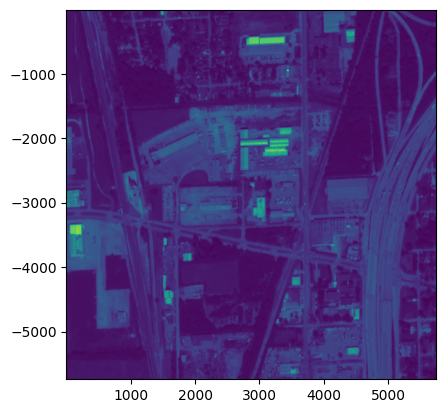

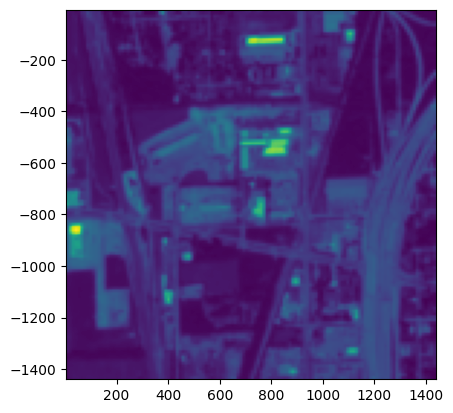

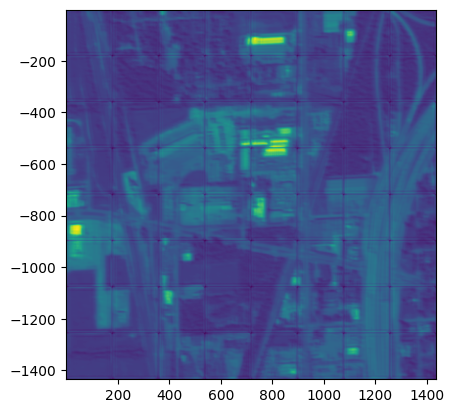

<Axes: >

In [43]:
gt = rasterio.open(r'/content/drive/MyDrive/PAirMax/GT/GT1.tif')
ms_lr = rasterio.open(r'/content/drive/MyDrive/PAirMax/RR/MS_LR/MS_LR1.tif')
out = rasterio.open(r'/content/drive/MyDrive/PAirMax/RR/PAN_SH/PAN_SH_MSDCNN.tif')
print(gt.shape)
print(ms_lr.shape)
show(gt)
show(ms_lr)
show(out)

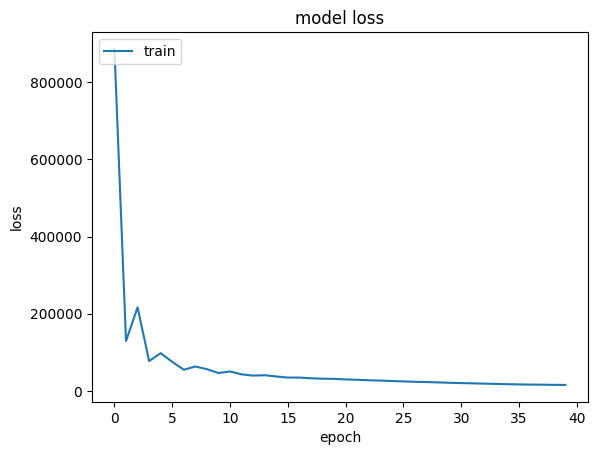

In [30]:
plt.plot(history3.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

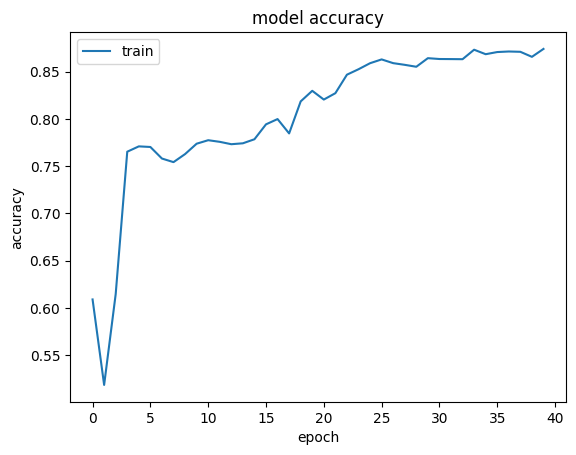

In [31]:
plt.plot(history3.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [34]:
with rasterio.open('/content/drive/MyDrive/PAirMax/GT/GT1.tif') as f:
        metadata = f.profile
        ms_img = np.transpose(f.read(tuple(np.arange(metadata['count']) + 1)), [1, 2, 0])
# with rasterio.open('../input/dataset4/PAN5.tif') as g:
#         metadata_pan = g.profile
#         pan_img = np.expand_dims(g.read(1), axis = 2)

# ms_to_pan_ratio = metadata['transform'][0] / metadata_pan['transform'][0]
with rasterio.open('/content/drive/MyDrive/PAirMax/RR/PAN_SH/PAN_SH_MSDCNN.tif') as f:
        metadata_out = f.profile
        out = np.transpose(f.read(tuple(np.arange(metadata_out['count']) + 1)), [1, 2, 0])


print("SAM: ", sam(out, ms_img))
print("ERGAS: ", ergas(out, ms_img,r=0.02))
print("UQI: ", uqi(out, ms_img))

print("D Lambda: ",d_lambda(ms_img,out))
print("VIFP: ",vifp(ms_img,out))

SAM:  0.13344242651404728
ERGAS:  0.29104280635110424
UQI:  0.9870436649215312
D Lambda:  0.01022855273384469
VIFP:  0.14457143457410082


# PSMD-Net(2020)

In [37]:
def PSMD_Net(input_shape=(64, 64, 5)):

  input_img = Input(input_shape)
  shallow_conv_1 = Conv2D(64,(9,9), activation='relu', padding='same')(input_img)
  shallow_conv_2 = Conv2D(32,(1,1), activation='relu', padding='same')(shallow_conv_1)
  shallow_conv_3 = Conv2D(4,(5,5), activation=None, padding='same')(shallow_conv_2)

  F0 = Conv2D(60,(5,5), activation=None, padding='same')(input_img)

  # MDB0
  deep_conv_01_sacle_1 = Conv2D(20,(3,3), activation='relu', padding='same')(F0)
  deep_conv_02_sacle_2 = Conv2D(20,(5,5),activation='relu', padding='same')(F0)
  deep_conv_03_sacle_3 = Conv2D(20,(7,7),activation='relu', padding='same')(F0)
  F0_1 = Concatenate()([deep_conv_01_sacle_1, deep_conv_02_sacle_2, deep_conv_03_sacle_3])
  F0_1 = Add()([F0, F0_1])

  deep_conv_11_sacle_1 = Conv2D(20,(3,3), activation='relu', padding='same')( F0_1)
  deep_conv_12_sacle_2 = Conv2D(20,(5,5),activation='relu', padding='same')( F0_1)
  deep_conv_13_sacle_3 = Conv2D(20,(7,7),activation='relu', padding='same')( F0_1)
  F0_2 = Concatenate()([deep_conv_11_sacle_1, deep_conv_12_sacle_2, deep_conv_13_sacle_3])
  F0_2 = Add()([F0, F0_1, F0_2])

  deep_conv_21_sacle_1 = Conv2D(20,(3,3), activation='relu', padding='same')( F0_2)
  deep_conv_22_sacle_2 = Conv2D(20,(5,5),activation='relu', padding='same')( F0_2)
  deep_conv_23_sacle_3 = Conv2D(20,(7,7),activation='relu', padding='same')( F0_2)
  F0_3 = Concatenate()([deep_conv_11_sacle_1, deep_conv_12_sacle_2, deep_conv_13_sacle_3])
  F0_3 = Add()([F0, F0_1, F0_2, F0_3])

  F1 = Conv2D(60,(1,1), activation=None, padding='same')(F0_3)

  # MDB1
  deep_conv_01_sacle_1 = Conv2D(20,(3,3), activation='relu', padding='same')(F1)
  deep_conv_02_sacle_2 = Conv2D(20,(5,5),activation='relu', padding='same')(F1)
  deep_conv_03_sacle_3 = Conv2D(20,(7,7),activation='relu', padding='same')(F1)
  F1_1 = Concatenate()([deep_conv_01_sacle_1, deep_conv_02_sacle_2, deep_conv_03_sacle_3])
  F1_1 = Add()([F1, F1_1])

  deep_conv_11_sacle_1 = Conv2D(20,(3,3), activation='relu', padding='same')( F1_1)
  deep_conv_12_sacle_2 = Conv2D(20,(5,5),activation='relu', padding='same')( F1_1)
  deep_conv_13_sacle_3 = Conv2D(20,(7,7),activation='relu', padding='same')( F1_1)
  F1_2 = Concatenate()([deep_conv_11_sacle_1, deep_conv_12_sacle_2, deep_conv_13_sacle_3])
  F1_2 = Add()([F1, F1_1, F1_2])

  deep_conv_21_sacle_1 = Conv2D(20,(3,3), activation='relu', padding='same')( F1_2)
  deep_conv_22_sacle_2 = Conv2D(20,(5,5),activation='relu', padding='same')( F1_2)
  deep_conv_23_sacle_3 = Conv2D(20,(7,7),activation='relu', padding='same')( F1_2)
  F1_3 = Concatenate()([deep_conv_11_sacle_1, deep_conv_12_sacle_2, deep_conv_13_sacle_3])
  F1_3 = Add()([F1, F1_1, F1_2, F1_3])

  F2 = Conv2D(60,(1,1), activation=None, padding='same')(F1_3)

  # MDB2
  deep_conv_01_sacle_1 = Conv2D(20,(3,3), activation='relu', padding='same')(F2)
  deep_conv_02_sacle_2 = Conv2D(20,(5,5),activation='relu', padding='same')(F2)
  deep_conv_03_sacle_3 = Conv2D(20,(7,7),activation='relu', padding='same')(F2)
  F2_1 = Concatenate()([deep_conv_01_sacle_1, deep_conv_02_sacle_2, deep_conv_03_sacle_3])
  F2_1 = Add()([F2, F2_1])

  deep_conv_11_sacle_1 = Conv2D(20,(3,3), activation='relu', padding='same')(F2_1)
  deep_conv_12_sacle_2 = Conv2D(20,(5,5),activation='relu', padding='same')(F2_1)
  deep_conv_13_sacle_3 = Conv2D(20,(7,7),activation='relu', padding='same')(F2_1)
  F2_2 = Concatenate()([deep_conv_11_sacle_1, deep_conv_12_sacle_2, deep_conv_13_sacle_3])
  F2_2 = Add()([F2, F2_1, F2_2])

  deep_conv_21_sacle_1 = Conv2D(20,(3,3), activation='relu', padding='same')( F2_2)
  deep_conv_22_sacle_2 = Conv2D(20,(5,5),activation='relu', padding='same')( F2_2)
  deep_conv_23_sacle_3 = Conv2D(20,(7,7),activation='relu', padding='same')( F2_2)
  F2_3 = Concatenate()([deep_conv_11_sacle_1, deep_conv_12_sacle_2, deep_conv_13_sacle_3])
  F2_3 = Add()([F2, F2_1, F2_2, F2_3])

  F3 = Conv2D(60,(1,1), activation=None, padding='same')(F0_3)

  Fg = Conv2D(64,(1,1), activation=None, padding='same')(F3)
  Fr = Conv2D(4,(3,3), activation=None, padding='same')(Fg)

  out = Add()([Fr,shallow_conv_3])

  PSMD = Model(input_img, out, name='PSMD_Net')
  # h = tensorflow.keras.losses.Huber()
  PSMD.compile(optimizer = Adam(learning_rate = 0.001), loss = 'mse', metrics = ['mse', 'accuracy'])

  return PSMD


In [38]:
model4 = MSDCNN()
model4.summary()

Model: "MSDCNN"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 64, 64, 5)]          0         []                            
                                                                                                  
 conv2d_59 (Conv2D)          (None, 64, 64, 60)           14760     ['input_7[0][0]']             
                                                                                                  
 conv2d_60 (Conv2D)          (None, 64, 64, 20)           10820     ['conv2d_59[0][0]']           
                                                                                                  
 conv2d_61 (Conv2D)          (None, 64, 64, 20)           30020     ['conv2d_59[0][0]']           
                                                                                             

In [39]:
history4 = model4.fit(train_full_array, img_full_array,
          batch_size=16,
          epochs=40,
          verbose=1,shuffle=True)

Epoch 1/40
2/2 [==============================] - 5s 63ms/step - loss: 1455813.0000 - mse: 1455813.0000 - accuracy: 0.6887
Epoch 2/40
2/2 [==============================] - 0s 52ms/step - loss: 191675.9688 - mse: 191675.9688 - accuracy: 0.1331
Epoch 3/40
2/2 [==============================] - 0s 39ms/step - loss: 323684.3750 - mse: 323684.3750 - accuracy: 0.2200
Epoch 4/40
2/2 [==============================] - 0s 40ms/step - loss: 229722.5625 - mse: 229722.5625 - accuracy: 0.2851
Epoch 5/40
2/2 [==============================] - 0s 34ms/step - loss: 77464.6641 - mse: 77464.6641 - accuracy: 0.7514
Epoch 6/40
2/2 [==============================] - 0s 33ms/step - loss: 123112.4141 - mse: 123112.4141 - accuracy: 0.7515
Epoch 7/40
2/2 [==============================] - 0s 35ms/step - loss: 77183.2031 - mse: 77183.2031 - accuracy: 0.7697
Epoch 8/40
2/2 [==============================] - 0s 32ms/step - loss: 68031.5078 - mse: 68031.5078 - accuracy: 0.7680
Epoch 9/40
2/2 [====================

In [40]:
output4=image_model_predict('/content/drive/MyDrive/PAirMax/RR/MS_LR/MS_LR1.tif', '/content/drive/MyDrive/PAirMax/RR/PAN/PAN1.tif', '/content/drive/MyDrive/PAirMax/RR/PAN_SH/PAN_SH_PSMD.tif',
                        64, 64, model4,
                        0, 1)

1/1 [==============================] - 0s 19ms/step


(512, 512)
(128, 128)


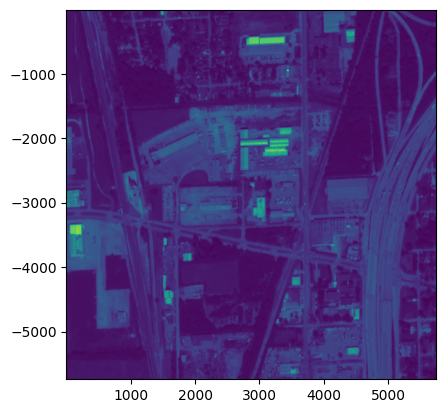

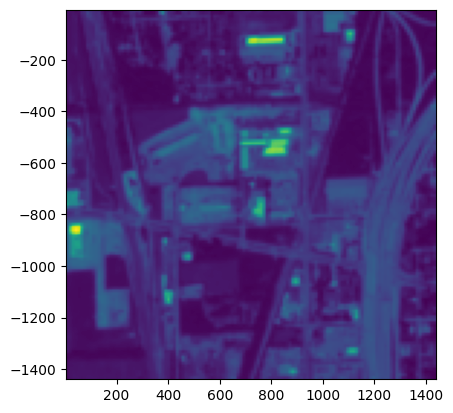

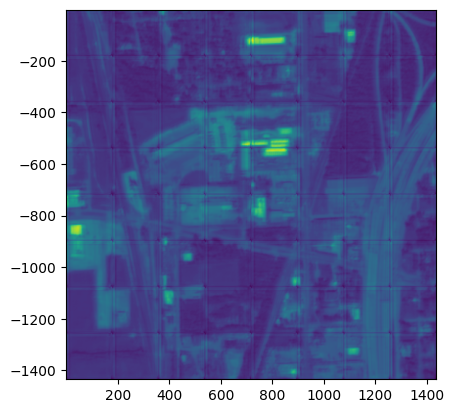

<Axes: >

In [44]:
gt = rasterio.open(r'/content/drive/MyDrive/PAirMax/GT/GT1.tif')
ms_lr = rasterio.open(r'/content/drive/MyDrive/PAirMax/RR/MS_LR/MS_LR1.tif')
out = rasterio.open(r'/content/drive/MyDrive/PAirMax/RR/PAN_SH/PAN_SH_PSMD.tif')
print(gt.shape)
print(ms_lr.shape)
show(gt)
show(ms_lr)
show(out)

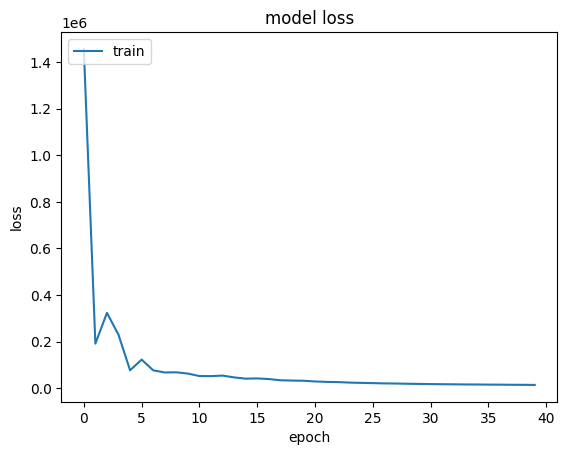

In [45]:
plt.plot(history4.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

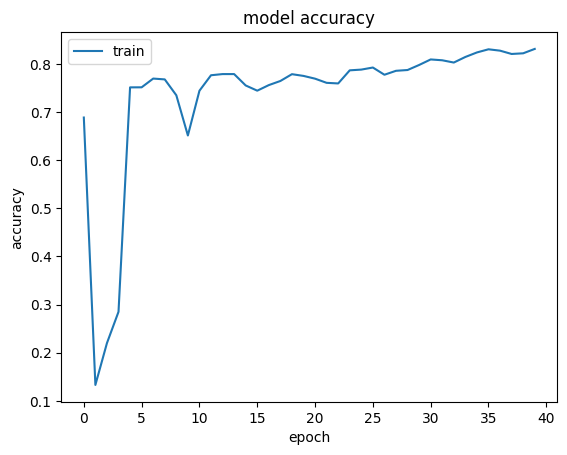

In [46]:
plt.plot(history4.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [47]:
with rasterio.open('/content/drive/MyDrive/PAirMax/GT/GT1.tif') as f:
        metadata = f.profile
        ms_img = np.transpose(f.read(tuple(np.arange(metadata['count']) + 1)), [1, 2, 0])
# with rasterio.open('../input/dataset4/PAN5.tif') as g:
#         metadata_pan = g.profile
#         pan_img = np.expand_dims(g.read(1), axis = 2)

# ms_to_pan_ratio = metadata['transform'][0] / metadata_pan['transform'][0]
with rasterio.open('/content/drive/MyDrive/PAirMax/RR/PAN_SH/PAN_SH_PSMD.tif') as f:
        metadata_out = f.profile
        out = np.transpose(f.read(tuple(np.arange(metadata_out['count']) + 1)), [1, 2, 0])


print("SAM: ", sam(out, ms_img))
print("ERGAS: ", ergas(out, ms_img,r=0.02))
print("UQI: ", uqi(out, ms_img))

print("D Lambda: ",d_lambda(ms_img,out))
print("VIFP: ",vifp(ms_img,out))

SAM:  0.12579577588775376
ERGAS:  0.278781554610579
UQI:  0.9892236099415478
D Lambda:  0.011498325173533292
VIFP:  0.1558594466085071


# SRPPNN(2021)

In [ ]:
def SRPNN(input_shape=(64, 64, 5)):

